# Advanced Analytics on Amazon SageMaker
---


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Compile](#Compile)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

The purpose of this lab is to demonstrate the basics of building an advanced analytics solution using Amazon SageMaker. In this notebook we will create a customer churn analytics solution by training an XGBoost churn model, and batching churn prediction scores into a data warehouse. 

We'll learn to query ground truth data from our data warehouse (Redshift) into this notebook, train an XGBoost model, and then  create a batch transform job to generate churn predictions. The churn predictions can be loaded back into Redshift where you can leverage your BI tool to obtain insights into customers who are at risk of churning.

The process outlined in this notebook is representative of what you might do during developing, but an automated production process will involve additional steps and tools that is beyond the practical scope of this lab.

---

## Prerequisites

The lab guide [here](https://github.com/dylan-tong-aws/aws-advanced-analytics-jumpstarter/blob/master/lab-guides/SageMaker%20Lab-Churn%20Predictive%20Analytics.pdf) takes you through the prerequite steps required by this notebook. 

In summaray:
 - Your notebook should be running in a VPC. 
 - You should have a Redshift cluster running in the same VPC, and region.
 - The security groups on your Redshift cluster and your notebook instance must permit TCP communication on port 5439.
 - The Redshift cluster has read access to an S3 bucket.
 

## Setup

_This notebook should run on any Amazon SageMaker notebook instance_

Let's first install the Redshift drivers on this notebook instance, so that we can query Redshift data directly from our notebook.

In [2]:
!conda install -y -c anaconda psycopg2

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/mxnet_p36

  added / updated specs: 
    - psycopg2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.1.23  |                0         126 KB  anaconda
    openssl-1.0.2s             |       h7b6447c_0         3.1 MB  anaconda
    psycopg2-2.7.4             |   py36hb7f436b_0         292 KB  anaconda
    certifi-2019.3.9           |           py36_0         155 KB  anaconda
    libpq-9.6.6                |       h1f21990_0         100 KB  anaconda
    ------------------------------------------------------------
                                           Total:         3.8 MB

The followin

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. Replace <<'REPLACE WITH YOUR BUCKET NAME'>> with the name of your bucket.

- The IAM role arn used to give training and hosting access to your data. By default, we'll use the IAM permissions that have been allocated to your notebook instance. The role should have the permissions to access your S3 bucket, and full execution permissions on Amazon SageMaker. In practice, you could minimize the scope of requried permissions.

In [62]:
import boto3
import psycopg2
import sqlalchemy as sa
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime

import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role

sess = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name

bucket = 'dtong-workshop'
##bucket = '<<REPLACE WITH YOUR BUCKET NAME>>'
prefix = 'churn-analytics-lab'

Provide the connection and credentials required to connect to your Redshift instance. 

In [4]:
creds = {
    "host_name": "workshop.cb9efiwnaas7.us-west-2.redshift.amazonaws.com",
    "port_num": "5439",
    "db_name": "dev",
    "username": "dbuser",
    "password": "R3dsh1ft123!"
}
print(creds)

def get_conn(creds): 
    conn = psycopg2.connect(dbname=creds['db_name'], 
                            user=creds['username'], 
                            password=creds['password'],
                            port=creds['port_num'],
                            host=creds['host_name'])
    return conn

{'host_name': 'workshop.cb9efiwnaas7.us-west-2.redshift.amazonaws.com', 'port_num': '5439', 'db_name': 'dev', 'username': 'dbuser', 'password': 'R3dsh1ft123!'}


In [5]:
cmd = 'CREATE TABLE call_stats( \
  state VARCHAR NOT NULL, \
  acctlen INT NOT NULL, \
  areacode INT2 NOT NULL, \
  phone VARCHAR NOT NULL, \
  intlplan VARCHAR NOT NULL, \
  vmailplan VARCHAR NOT NULL, \
  vmailmsg INT NOT NULL, \
  daymins REAL NOT NULL, \
  daycalls INT NOT NULL, \
  daycharge REAL NOT NULL, \
  evemins REAL NOT NULL, \
  evecalls INT NOT NULL, \
  evecharge REAL NOT NULL, \
  nightmins REAL NOT NULL, \
  nightcalls INT NOT NULL, \
  nightcharge REAL NOT NULL, \
  intlmins REAL NOT NULL, \
  intlcalls INT NOT NULL, \
  intlcharge REAL NOT NULL, \
  custservcalls INT NOT NULL, \
  churn VARCHAR NOT NULL);'

def create_table() :
    try :
        conn = None
        with get_conn(creds) as conn:
            with conn.cursor() as cur:
                cur.execute(cmd)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
                
create_table()

Relation "call_stats" already exists



In [43]:
p= os.path.join(bucket,prefix)
print(p)

dtong-workshop/churn-analytics-lab


In [40]:
x = '{}/{}/datasets/raw'.format(bucket,prefix)
print(x)

dtong-workshop/churn-analytics-lab/datasets/raw


In [73]:
import os

RAWDATA_S3URI = 's3://reinvent2018-sagemaker-pytorch/datasets/uci-telco-churn/raw/churn.csv'
DATASOURCE_PREFIX = '{}/datasets/raw'.format(prefix)
DATASOURCE_S3URI = 's3://{}/{}/{}'.format(bucket,DATASOURCE_PREFIX,'churn.csv')

os.system('aws s3 cp {} {}/{} --quiet --source-region us-east-1 --region {}'.format(DOWNLOAD_S3URI,RAWDATA_S3URI,'churn.csv',region))

print("Data set downloaded to your S3 bucket at: {}".format(DATASOURCE_S3URI))

Data set downloaded to your S3 bucket at: s3://dtong-workshop/churn-analytics-lab/datasets/raw/churn.csv


In [8]:
REDSHIFT_IAM_ROLE = 'arn:aws:iam::803235869972:role/MyRedshiftRole'

cmd = "COPY call_stats from \
'{}' IAM_ROLE '{}' DELIMITER ','".format(DATASOURCE_S3URI,REDSHIFT_IAM_ROLE);

def load_data() :
    try :
        conn = None
        with get_conn(creds) as conn:
            with conn.cursor() as cur:
                cur.execute(cmd)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

start = time.time()         
load_data()
end = time.time()

print("Data was loaded in {} seconds.".format(end-start))

Data was loaded in 13.135110855102539 seconds.


---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [27]:
# Sample query for testing
query = 'select * from public.call_stats;'

colnames = ['State','Account Length','Area Code','Phone','Intl Plan', 'VMail Plan', 'VMail Message','Day Mins',
            'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls','Night Charge',
            'Intl Mins','Intl Calls','Intl Charge','CustServ Calls', 'Churn?']

def get_df(creds, query):
    with get_conn(creds) as conn:
        with conn.cursor() as cur:
            cur.execute(query)
            result_set = cur.fetchall()
          #  colnames = [desc.name for desc in cur.description]
            df = pd.DataFrame.from_records(result_set, columns=colnames)
    return df

churn = get_df(creds, query)

display(churn)

,State,Account Length,Area Code,Phone,Intl Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
2,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
3,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,...,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
4,LA,117,408,335-4719,no,no,0,184.5,97,31.37,...,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
5,IN,65,415,329-6603,no,no,0,129.1,137,21.95,...,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True.
6,IA,168,408,363-1107,no,no,0,128.8,96,21.90,...,71,8.92,141.1,128,6.35,11.2,2,3.02,1,False.
7,IA,62,415,366-9238,no,no,0,120.7,70,20.52,...,76,26.11,203.0,99,9.14,13.1,6,3.54,4,False.
8,ID,85,408,350-8884,no,yes,27,196.4,139,33.39,...,90,23.88,89.3,75,4.02,13.8,4,3.73,1,False.
9,VA,76,510,356-2992,no,yes,33,189.7,66,32.25,...,65,18.09,165.7,108,7.46,10.0,5,2.70,1,False.


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
327-3954,0.0003
327-4795,0.0003
327-5525,0.0003
327-5817,0.0003


col_0,% observations
Intl Plan,
no,0.90309
yes,0.09691


col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628


col_0,% observations
Churn?,
False.,0.855086
True.,0.144914


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.818123,42.367052,13.686996,54.461941,20.067077,9.258508,50.708772,19.920633,4.310236,50.568788,19.566652,2.275645,2.791560,2.460968,0.753697,1.315359
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


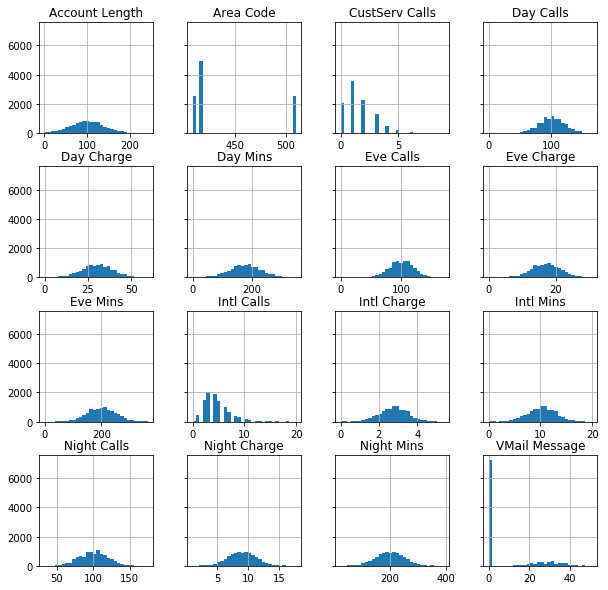

In [28]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that:
- `State` appears to be quite evenly distributed
- `Phone` takes on too many unique values to be of any practical use.  It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity.  `VMail Message` being a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).

In [29]:
churn = churn.drop('Phone', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

In [30]:
display(churn)

,State,Account Length,Area Code,Intl Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
2,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
3,MA,121,510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
4,LA,117,408,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
5,IN,65,415,no,no,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True.
6,IA,168,408,no,no,0,128.8,96,21.90,104.9,71,8.92,141.1,128,6.35,11.2,2,3.02,1,False.
7,IA,62,415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,False.
8,ID,85,408,no,yes,27,196.4,139,33.39,280.9,90,23.88,89.3,75,4.02,13.8,4,3.73,1,False.
9,VA,76,510,no,yes,33,189.7,66,32.25,212.8,65,18.09,165.7,108,7.46,10.0,5,2.70,1,False.


Next let's look at the relationship between each of the features and our target variable.

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn?,False.,True.
Area Code,,
408,0.251228,0.252588
415,0.497895,0.488613
510,0.250877,0.258799


Churn?,False.,True.
Intl Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


Account Length


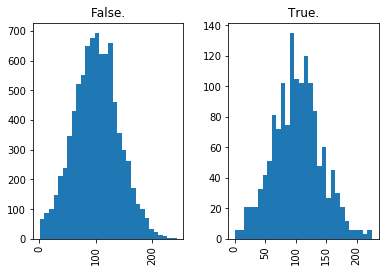

VMail Message


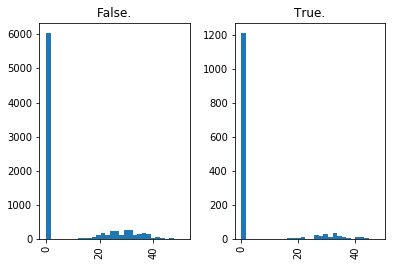

Day Mins


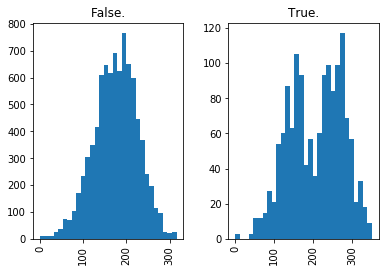

Day Calls


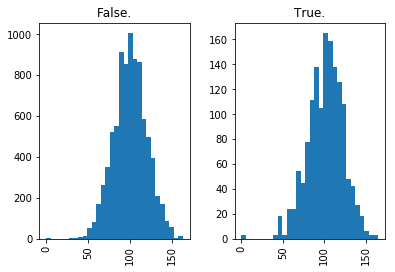

Day Charge


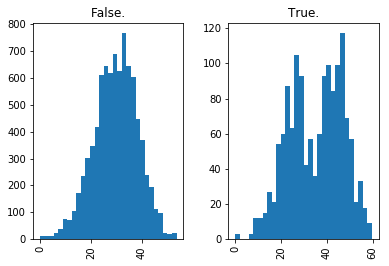

Eve Mins


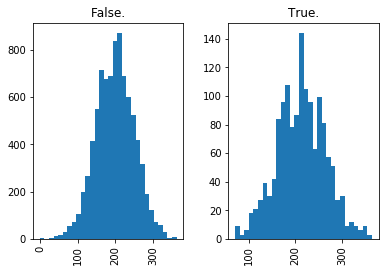

Eve Calls


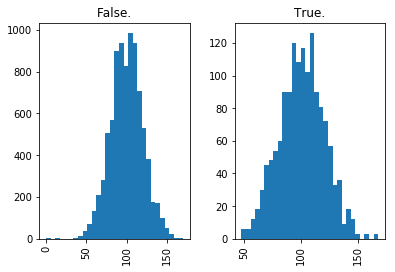

Eve Charge


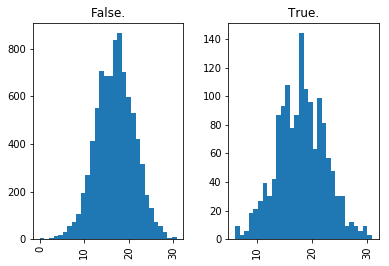

Night Mins


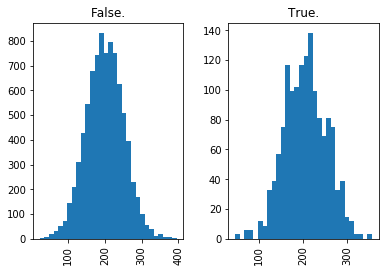

Night Calls


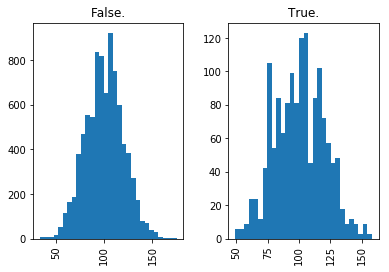

Night Charge


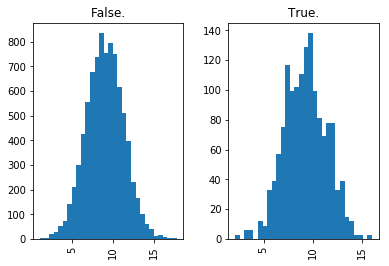

Intl Mins


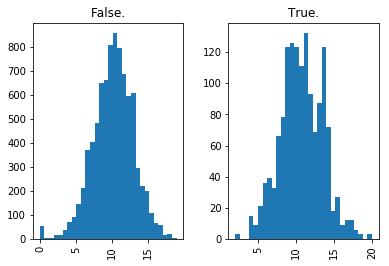

Intl Calls


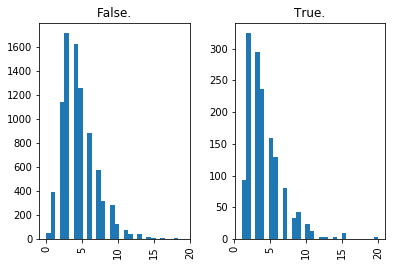

Intl Charge


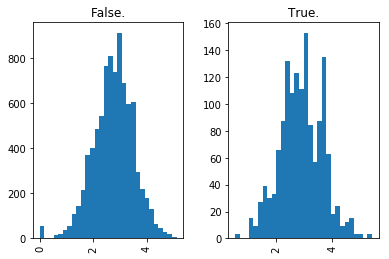

CustServ Calls


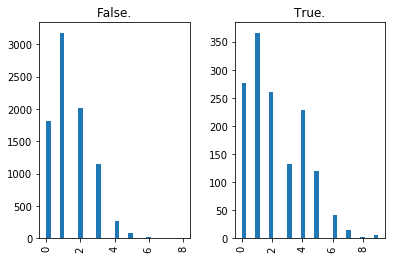

In [11]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

Interestingly we see that churners appear:
- Fairly evenly distributed geographically
- More likely to have an international plan
- Less likely to have a voicemail plan
- To exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
- To have a larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)

In addition, we see that churners take on very similar distributions for features like `Day Mins` and `Day Charge`.  That's not surprising as we'd expect minutes spent talking to correlate with charges.  Let's dig deeper into the relationships between our features.

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
VMail Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288
Night Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802


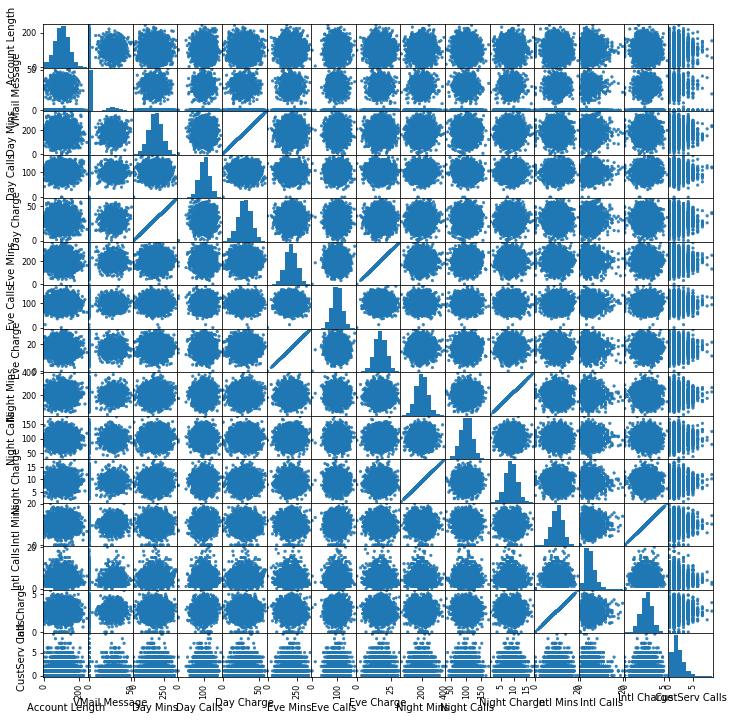

In [12]:
display(churn.corr())
pd.plotting.scatter_matrix(churn, figsize=(12, 12))
plt.show()

We see several features that essentially have 100% correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.  Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [13]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

In [14]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [15]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [37]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
display(train_data)

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Intl Plan_no,Intl Plan_yes,VMail Plan_no,VMail Plan_yes
5121,0,78,0,252.9,93,178.4,112,263.9,105,9.5,7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3835,0,50,0,154.7,102,298.0,108,210.2,95,11.1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
7821,0,141,0,151.5,104,242.2,114,304.2,109,10.8,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0
4536,0,165,33,111.6,140,213.3,111,267.6,115,16.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
8261,1,87,0,240.0,83,134.1,106,189.1,84,9.3,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
8008,0,64,0,213.5,93,166.6,114,122.0,78,14.1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
9214,1,77,0,245.2,87,254.1,83,239.4,91,7.5,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3070,0,128,40,171.2,88,145.7,109,196.8,93,14.0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1
5553,0,87,0,167.3,119,198.5,119,133.1,88,11.0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
4092,0,134,0,183.8,111,123.5,92,160.7,105,6.1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0


Now we'll upload these files to S3.

In [31]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [106]:
from sagemaker.amazon.amazon_estimator import get_image_uri
xgb_training_container = get_image_uri(boto3.Session().region_name, 'xgboost')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [99]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [100]:
xgb = sagemaker.estimator.Estimator(xgb_training_container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-06-08 06:39:24 Starting - Starting the training job...
2019-06-08 06:39:26 Starting - Launching requested ML instances......
2019-06-08 06:40:30 Starting - Preparing the instances for training......
2019-06-08 06:41:45 Downloading - Downloading input data
2019-06-08 06:41:45 Training - Downloading the training image..
Arguments: train
[2019-06-08:06:42:04:INFO] Running standalone xgboost training.
[2019-06-08:06:42:04:INFO] File size need to be processed in the node: 1.38mb. Available memory size in the node: 8480.67mb
[2019-06-08:06:42:04:INFO] Determined delimiter of CSV input is ','
[06:42:04] S3DistributionType set as FullyReplicated
[06:42:04] 6999x69 matrix with 482931 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-06-08:06:42:04:INFO] Determined delimiter of CSV input is ','
[06:42:04] S3DistributionType set as FullyReplicated
[06:42:04] 2000x69 matrix with 138000 entries loaded from /opt/ml/input/data/validation?format=csv&label_co


2019-06-08 06:42:16 Uploading - Uploading generated training model
2019-06-08 06:42:16 Completed - Training job completed
Billable seconds: 48


---
## Compile
[Amazon SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) optimizes models to run up to twice as fast, with no loss in accuracy. When calling `compile_model()` function, we specify the target instance family (m4) as well as the S3 bucket to which the compiled model would be stored.

In [101]:
compiled_model = xgb
try:
    xgb.create_model()._neo_image_account(boto3.Session().region_name)
except:
    print('Neo is not currently supported in', boto3.Session().region_name)
else:
    output_path = '/'.join(xgb.output_path.split('/')[:-1])
    compiled_model = xgb.compile_model(target_instance_family='ml_m5', 
                                   input_shape={'data':[1, 69]},
                                   role=role,
                                   framework='xgboost',
                                   framework_version='0.7',
                                   output_path=output_path)
    compiled_model.name = 'deployed-xgboost-customer-churn'
    compiled_model.image = get_image_uri(sess.boto_region_name, 'xgboost-neo', repo_version='latest')

?..!

In [102]:
batch_input = test_data.iloc[:,1:]
batch_input.to_csv('test.csv', header=False, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

s3uri_batch_input ='s3://{}/{}/test'.format(bucket, prefix)
print(s3uri_batch_input)

s3uri_batch_output= 's3://{}/{}/out'.format(bucket, prefix)
print(s3uri_batch_output)

s3://dtong-workshop/churn-analytics-lab/test
s3://dtong-workshop/churn-analytics-lab/out


In [103]:
from sagemaker.transformer import Transformer
BATCH_INSTANCE_TYPE = 'ml.c5.xlarge'

transformer = compiled_model.transformer(instance_count=1,
                                         strategy='SingleRecord',
                                         assemble_with='Line',
                                         instance_type= BATCH_INSTANCE_TYPE,
                                         accept = 'text/csv',
                                         output_path=s3uri_batch_output)
    
transformer.transform(s3uri_batch_input, split_type= 'Line', content_type= 'text/csv')

---
## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [ ]:
xgb_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [ ]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [ ]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

dtest = test_data.as_matrix()
predictions = []
for i in range(dtest.shape[0]):
    predictions.append(predict(dtest[i:i+1, 1:]))
predictions = np.array(predictions).squeeze()

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

In [ ]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

_Note, due to randomized elements of the algorithm, you results may differ slightly._

Of the 48 churners, we've correctly predicted 39 of them (true positives). And, we incorrectly predicted 4 customers would churn who then ended up not doing so (false positives).  There are also 9 customers who ended up churning, that we predicted would not (false negatives).

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

In [ ]:
plt.hist(predictions)
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [ ]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives.  The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives.  Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \$100. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the \$100 concession. We probably could have spent that \$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

In [ ]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly.  The overall cost can be minimized at \$8400 by setting the cutoff to 0.46, which is substantially better than the \$20k+ I would expect to lose by not taking any action.

---
## Extensions

This notebook showcased how to build a model that predicts whether a customer is likely to churn, and then how to optimally set a threshold that accounts for the cost of true positives, false positives, and false negatives.  There are several means of extending it including:
- Some customers who receive retention incentives will still churn.  Including a probability of churning despite receiving an incentive in our cost function would provide a better ROI on our retention programs.
- Customers who switch to a lower-priced plan or who deactivate a paid feature represent different kinds of churn that could be modeled separately.
- Modeling the evolution of customer behavior. If usage is dropping and the number of calls placed to Customer Service is increasing, you are more likely to experience churn then if the trend is the opposite. A customer profile should incorporate behavior trends.
- Actual training data and monetary cost assignments could be more complex.
- Multiple models for each type of churn could be needed.

Regardless of additional complexity, similar principles described in this notebook are likely apply.

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

## test

In [48]:
!pygmentize ../scripts/churn-analytics.py

from __future__ import print_function
from __future__ import unicode_literals

import time
import sys
import os
import shutil
import csv

import boto3

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.functions import col
from mleap.pyspark.spark_support import SimpleSparkSerializer

def csv_line(data):
    s = str(data[0])
    a = data[1].toArray() 
    for i in range(len(a)) :
        s += ','+str(a[i])
    return s

def main():
    spark = SparkSession.builder.appName("churn-analytics").getOrCreate()
    
    args = getResolvedOptions(sys.argv, ['S3_INPUT_BUCKET',
                                         'S3_INPUT_KEY_PREFIX',
                                         'S3_OUTPUT_BUCKET',
                                         'S3_OUTPUT_KEY_PREFIX', 
                

In [65]:
SCRIPTS_DOWNLOAD_S3URI = 's3://reinvent2018-sagemaker-pytorch/scripts/workshops/churn-analytics/churn-analytics.py'
script_location = 's3://{}/{}/scripts/churn-analytics.py'.format(bucket,prefix)

start = time.time()
os.system('aws s3 cp {} {} --quiet --source-region us-west-2 --region {}' \
          .format(SCRIPTS_DOWNLOAD_S3URI,script_location, region))
end = time.time()

print("Scripts were downloaded to {} in {} seconds.".format(script_location,end-start))

Scripts were downloaded to s3://dtong-workshop/churn-analytics-lab/scripts/churn-analytics.py in 0.7990262508392334 seconds.


### Upload MLeap dependencies to S3

For our job, we will also have to pass MLeap dependencies to Glue. MLeap is an additional library we are using which does not come bundled with default Spark.

Similar to most of the packages in the Spark ecosystem, MLeap is also implemented as a Scala package with a front-end wrapper written in Python so that it can be used from PySpark. We need to make sure that the MLeap Python library as well as the JAR is available within the Glue job environment. In the following cell, we will download the MLeap Python dependency & JAR from a SageMaker hosted bucket and upload to the S3 bucket we created above in your account. 

If you are using some other Python libraries like `nltk` in your code, you need to download the wheel file from PyPI and upload to S3 in the same way. At this point, Glue only supports passing pure Python libraries in this way (e.g. you can not pass `Pandas` or `OpenCV`). However you can use `NumPy` & `SciPy` without having to pass these as packages because these are pre-installed in the Glue environment. 

In [53]:
!wget https://s3-us-west-2.amazonaws.com/sparkml-mleap/0.9.6/python/python.zip
!wget https://s3-us-west-2.amazonaws.com/sparkml-mleap/0.9.6/jar/mleap_spark_assembly.jar    

--2019-06-07 06:52:01--  https://s3-us-west-2.amazonaws.com/sparkml-mleap/0.9.6/python/python.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.240.32
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.240.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36872 (36K) [application/zip]
Saving to: ‘python.zip’

python.zip          100%[===================>]  36.01K  --.-KB/s    in 0.001s  

2019-06-07 06:52:01 (42.2 MB/s) - ‘python.zip’ saved [36872/36872]

--2019-06-07 06:52:01--  https://s3-us-west-2.amazonaws.com/sparkml-mleap/0.9.6/jar/mleap_spark_assembly.jar
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.240.32
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.240.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17319576 (17M) [application/java-archive]
Saving to: ‘mleap_spark_assembly.jar’

mleap_spark_assembl 100%[=

In [56]:
python_dep_location = sess.upload_data(path='python.zip', bucket=bucket, key_prefix='dependencies/python')
jar_dep_location = sess.upload_data(path='mleap_spark_assembly.jar', bucket=bucket, key_prefix='dependencies/jar')

## Defining output locations for the data and model
Next we define the output location where the transformed dataset should be uploaded. We are also specifying a model location where the MLeap serialized model would be updated. This locations should be consumed as part of the Spark script using `getResolvedOptions` method of AWS Glue library (see `abalone_processing.py` for details).

By designing our code in that way, we can re-use these variables as part of other SageMaker operations from this Notebook (details below).

In [74]:
from time import gmtime, strftime
import time

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Input location of the data, We uploaded our train.csv file to input key previously
s3_input_bucket = bucket
s3_input_key_prefix = DATASOURCE_PREFIX

# Output location of the data. The input data will be split, transformed, and 
# uploaded to output/train and output/validation
s3_output_bucket = bucket
s3_output_key_prefix = timestamp_prefix + '/churn'

# the MLeap serialized SparkML model will be uploaded to output/mleap
s3_model_bucket = bucket
s3_model_key_prefix = s3_output_key_prefix + '/mleap'

### Calling Glue APIs

Next we'll be creating Glue client via Boto so that we can invoke the `create_job` API of Glue. `create_job` API will create a job definition which can be used to execute your jobs in Glue. The job definition created here is mutable. While creating the job, we are also passing the code location as well as the dependencies location to Glue.

`AllocatedCapacity` parameter controls the hardware resources that Glue will use to execute this job. It is measures in units of `DPU`. For more information on `DPU`, please see [here](https://docs.aws.amazon.com/glue/latest/dg/add-job.html).

In [76]:
glue_client = boto_session.client('glue')
job_name = 'churn-analytics-pipeline-' + timestamp_prefix
response = glue_client.create_job(
    Name=job_name,
    Description='PySpark job to featurize the telco churn dataset',
    Role=role, # you can pass your existing AWS Glue role here if you have used Glue before
    ExecutionProperty={
        'MaxConcurrentRuns': 1
    },
    Command={
        'Name': 'glueetl',
        'ScriptLocation': script_location
    },
    DefaultArguments={
        '--job-language': 'python',
        '--extra-jars' : jar_dep_location,
        '--extra-py-files': python_dep_location
    },
    AllocatedCapacity=5,
    Timeout=60,
)
glue_job_name = response['Name']
print(glue_job_name)

churn-analytics-pipeline-2019-06-07-19-53-37


The aforementioned job will be executed now by calling `start_job_run` API. This API creates an immutable run/execution corresponding to the job definition created above. We will require the `job_run_id` for the particular job execution to check for status. We'll pass the data and model locations as part of the job execution parameters.

In [149]:
glue_job_args = {
                                        '--S3_INPUT_BUCKET': s3_input_bucket,
                                        '--S3_INPUT_KEY_PREFIX': s3_input_key_prefix,
                                        '--S3_OUTPUT_BUCKET': s3_output_bucket,
                                        '--S3_OUTPUT_KEY_PREFIX': s3_output_key_prefix,
                                        '--S3_MODEL_BUCKET': s3_model_bucket,
                                        '--S3_MODEL_KEY_PREFIX': s3_model_key_prefix
                                       }
    
job_run_id = glue_client.start_job_run(JobName=job_name,
                                       Arguments = glue_job_args)['JobRunId']
print('Running Job ID: {}'.format(job_run_id))
print('Arguments provided: {}'.format(glue_job_args))

Running Job ID: jr_e970842638a581595199dbea7fcc01f283a8a9d76bab09be8c409e83a8cb9f18
Arguments provided: {'--S3_INPUT_BUCKET': 'dtong-workshop', '--S3_INPUT_KEY_PREFIX': 'churn-analytics-lab/datasets/raw', '--S3_OUTPUT_BUCKET': 'dtong-workshop', '--S3_OUTPUT_KEY_PREFIX': '2019-06-07-19-53-37/churn', '--S3_MODEL_BUCKET': 'dtong-workshop', '--S3_MODEL_KEY_PREFIX': '2019-06-07-19-53-37/churn/mleap'}


### Checking Glue job status

Now we will check for the job status to see if it has `succeeded`, `failed` or `stopped`. Once the job is succeeded, we have the transformed data into S3 in CSV format which we can use with XGBoost for training. If the job fails, you can go to [AWS Glue console](https://us-west-2.console.aws.amazon.com/glue/home), click on **Jobs** tab on the left, and from the page, click on this particular job and you will be able to find the CloudWatch logs (the link under **Logs**) link for these jobs which can help you to see what exactly went wrong in the job execution.

In [150]:
job_run_status = glue_client.get_job_run(JobName=job_name,RunId=job_run_id)['JobRun']['JobRunState']
while job_run_status not in ('FAILED', 'SUCCEEDED', 'STOPPED'):
    job_run_status = glue_client.get_job_run(JobName=job_name,RunId=job_run_id)['JobRun']['JobRunState']
    print (job_run_status)
    time.sleep(30)

RUNNING
RUNNING
RUNNING
SUCCEEDED


## Using SageMaker XGBoost to train on the processed dataset produced by SparkML job

Now we will use SageMaker XGBoost algorithm to train on this dataset. We already know the S3 location
where the preprocessed training data was uploaded as part of the Glue job.

### We need to retrieve the XGBoost algorithm image
We will retrieve the XGBoost built-in algorithm image so that it can leveraged for the training job.

In [86]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'xgboost', repo_version="latest")
print (training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest


### Next XGBoost model parameters and dataset details will be set properly
We have parameterized this Notebook so that the same data location which was used in the PySpark script can now be passed to XGBoost Estimator as well.

# Building an Inference Pipeline consisting of SparkML & XGBoost models for a realtime inference endpoint

Next we will proceed with deploying the models in SageMaker to create an Inference Pipeline. You can create an Inference Pipeline with upto five containers.

Deploying a model in SageMaker requires two components:

* Docker image residing in ECR.
* Model artifacts residing in S3.

**SparkML**

For SparkML, Docker image for MLeap based SparkML serving is provided by SageMaker team. For more information on this, please see [SageMaker SparkML Serving](https://github.com/aws/sagemaker-sparkml-serving-container). MLeap serialized SparkML model was uploaded to S3 as part of the SparkML job we executed in AWS Glue.

**XGBoost**

For XGBoost, we will use the same Docker image we used for training. The model artifacts for XGBoost was uploaded as part of the training job we just ran.


### Passing the schema of the payload via environment variable
SparkML serving container needs to know the schema of the request that'll be passed to it while calling the `predict` method. In order to alleviate the pain of not having to pass the schema with every request, `sagemaker-sparkml-serving` allows you to pass it via an environment variable while creating the model definitions. This schema definition will be required in our next step for creating a model.

We will see later that you can overwrite this schema on a per request basis by passing it as part of the individual request payload as well.

In [154]:
import json

schema = {
    "input": [{"name": "State","type": "string"}, 
              {"name": "AccountLength", "type": "int"}, 
              {"name": "AreaCode","type": "int"}, 
              {"name": "Phone","type": "string"}, 
              {"name": "IntlPlan","type": "string"}, 
              {"name": "VMailPlan","type": "string"},
              {"name": "VMailMessage","type": "int"},
              {"name": "DayMins","type": "float"},
              {"name": "DayCalls","type": "int"},
              {"name": "DayCharge","type": "float"},
              {"name": "EveMins","type": "float"},
              {"name": "EveCalls","type": "int"},
              {"name": "EveCharge","type": "float"},
              {"name": "NightMins","type": "float"},
              {"name": "NightCalls","type": "int"},
              {"name": "NightCharge","type": "float"},
              {"name": "IntlMins","type": "float"},
              {"name": "IntlCalls","type": "int"},
              {"name": "IntlCharge","type": "float"},
              {"name": "CustServCalls","type": "int"},],
    "output": {"name": "features","type": "double","struct": "vector"}
}

schema_json = json.dumps(schema)
print(schema_json)

{"input": [{"name": "State", "type": "string"}, {"name": "AccountLength", "type": "int"}, {"name": "AreaCode", "type": "int"}, {"name": "Phone", "type": "string"}, {"name": "IntlPlan", "type": "string"}, {"name": "VMailPlan", "type": "string"}, {"name": "VMailMessage", "type": "int"}, {"name": "DayMins", "type": "float"}, {"name": "DayCalls", "type": "int"}, {"name": "DayCharge", "type": "float"}, {"name": "EveMins", "type": "float"}, {"name": "EveCalls", "type": "int"}, {"name": "EveCharge", "type": "float"}, {"name": "NightMins", "type": "float"}, {"name": "NightCalls", "type": "int"}, {"name": "NightCharge", "type": "float"}, {"name": "IntlMins", "type": "float"}, {"name": "IntlCalls", "type": "int"}, {"name": "IntlCharge", "type": "float"}, {"name": "CustServCalls", "type": "int"}], "output": {"name": "features", "type": "double", "struct": "vector"}}


### Creating a `PipelineModel` which comprises of the SparkML and XGBoost model in the right order

Next we'll create a SageMaker `PipelineModel` with SparkML and XGBoost.The `PipelineModel` will ensure that both the containers get deployed behind a single API endpoint in the correct order. The same model would later be used for Batch Transform as well to ensure that a single job is sufficient to do prediction against the Pipeline. 

Here, during the `Model` creation for SparkML, we will pass the schema definition that we built in the previous cell.

In [155]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
from sagemaker.sparkml.model import SparkMLModel
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'xgboost', repo_version="latest")
print (training_image)

sparkml_data = 's3://{}/{}/{}'.format(s3_model_bucket, s3_model_key_prefix, 'model.tar.gz')
# passing the schema defined above by using an environment variable that sagemaker-sparkml-serving understands
sparkml_model = SparkMLModel(model_data=sparkml_data, env={'SAGEMAKER_SPARKML_SCHEMA' : schema_json})
xgb_model = Model(model_data=xgb.model_data, image=xgb_training_container)

model_name = 'inference-pipeline-' + timestamp_prefix
sm_model = PipelineModel(name=model_name, role=role, models=[sparkml_model, xgb_model])

433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest


In [156]:
sm_model.sagemaker_session = sess
container_def = sm_model.pipeline_container_def(instance_type=BATCH_INSTANCE_TYPE)
sess.create_model(model_name, role, container_def)

'inference-pipeline-2019-06-07-19-53-37'

### Deploying the `PipelineModel` to an endpoint for realtime inference
Next we will deploy the model we just created with the `deploy()` method to start an inference endpoint and we will send some requests to the endpoint to verify that it works as expected.

In [108]:
endpoint_name = 'inference-pipeline-ep-' + timestamp_prefix
sm_model.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge', endpoint_name=endpoint_name)

------------------------------------------------------------------------------------------!

#### Passing the payload in CSV format
We will first see how the payload can be passed to the endpoint in CSV format.

In [157]:
s3uri_batch_output = 's3://{}/{}/pipeline/out'.format(bucket, prefix)
s3uri_batch_input= 's3://reinvent2018-sagemaker-pytorch/datasets/uci-telco-churn/raw/churn_nolabels.csv'    

transformer = sagemaker.transformer.Transformer(model_name = model_name,
                                                instance_count=1,
                                                strategy='SingleRecord',
                                                assemble_with='Line',
                                                instance_type= BATCH_INSTANCE_TYPE,
                                                accept = 'text/csv',
                                                sagemaker_session=sess,
                                                base_transform_job_name='serial-inference-batch',
                                                output_path=s3uri_batch_output)
 
transformer.transform(s3uri_batch_input, split_type= 'Line', content_type= 'text/csv')